##Imports/Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import datetime
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, confusion_matrix
from sklearn.model_selection import KFold


import lightgbm as lgb
from lightgbm import LGBMClassifier

from scipy import sparse

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


from google.colab import drive
drive.mount('/content/drive/')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive/


##Global Parameters

In [2]:
FIG_SIZE = (15, 12)
FONT_SIZE = 20

##Function Definitions

In [3]:
def read_tsv(path):
    df = pd.read_csv(path, sep="\t")
    return df.drop(columns=df.columns[0])

In [6]:
def map_effectiveness(e):
  if e == "Highly Effective":
    return 5
  elif e == "Considerably Effective":
    return 4
  elif e == "Marginally Effective":
    return 3
  elif e == "Moderately Effective":
    return 2
  elif e == "Ineffective":
    return 1
  else:
    pass

In [7]:
def map_side_effects(s):
  if s == "Extremely Severe Side Effects":
    return 1
  elif s == "Severe Side Effects":
    return 2
  elif s == "Moderate Side Effects":
    return 3
  elif s == "Mild Side Effects":
    return 4
  elif s == "No Side Effects":
    return 5
  else:
    pass

In [8]:
def clean_condition(c):
  if "birth" in c:
    return "Birth Control"
  elif "pregnancy" in c:
    return "Birth Control"
  elif "pregnant" in c:
    return "Birth Control"
  elif "add" in c:
    return "ADHD"
  elif "adhd" in c:
    return "ADHD"
  elif "acne" in c:
    return "Acne"
  elif "headache" in c:
    return "Migraine"
  elif "migraine" in c:
    return "Migraine"
  elif "depression" in c:
    return "Depression"
  elif "heratburn" in c:
    return "GERD"
  elif "heartburn" in c:
    return "GERD"
  elif "gerd" in c:
    return "GERD"
  elif "acid" in c:
    return "GERD"
  elif "insomnia" in c:
    return "Insomnia"
  elif "sleeplessness" in c:
    return "Insomnia"
  elif "weight" in c:
    return "Weight Loss"
  elif "pounds" in c:
    return "Weight Loss"
  elif "pain" in c:
    return "Pain"
  elif "smoking" in c:
    return "Smoking Cessation"
  elif "lbs" in c:
    return "Weight Loss"
  elif "addixtion" in c:
    return "Addiction"
  elif "allergy" in c:
    return "Allergies"
  elif "allergies" in c:
    return "Allergies"
  elif "polar" in c:
    return "Bipolar Disorder"
  elif "bipolar" in c:
    return "Bipolar Disorder"
  elif "anxiety" in c:
    return "Anxiety"
  elif "blood pressure" in c:
    return "High Blood Pressure"
  elif "epilepsy" in c:
    return "Epilepsy"
  elif "menopause" in c:
    return "Menopause"
  elif "heart failure" in c:
    return "Heart Failure"
  elif "flu" in c:
    return "Flu"
  elif "bipol" in c:
    return "Bipolar Disorder"
  elif "arthiritis" in c:
    return "Arthritis"
  elif "arthritis" in c:
    return "Arthritis"
  elif "hypertension" in c:
    return "Hypertension"
  elif "asthma" in c:
    return "Asthma"
  elif "fibromyalgia" in c:
    return "Fibromyalgia"
  elif "Fibromyalga" in c:
    return "Fibromyalgia"
  elif "fybromyalgia" in c:
    return "Fibromyalgia"
  elif "sinus" in c:
    return "Sinusitis"
  elif "panic" in c:
    return "Panic Attacks"
  elif "hair loss" in c:
    return "Hair Loss"
  elif "fatigue" in c:
    return "Fatigue"
  elif "asleep" in c:
    return "Insomnia"
  elif "hair" in c:
    return "Hair Loss"
  elif "nausea" in c:
    return "Nausea"
  elif "fungal" in c:
    return "Fungal Infection"
  elif "fungus" in c:
    return "Fungal Infection"
  elif "wrinkles" in c:
    return "Skin Care"
  elif "facial" in c:
    return "Skin Care"
  elif "fever" in c:
    return "Fever"
  elif "hot flash" in c:
    return "Hot Flash"
  elif "hypercholesteremia" in c:
    return "Hypercholesterolemia"
  elif "hypercholesterolemia" in c:
    return "Hypercholesterolemia"
  elif "hypthyr" in c:
    return "Hypothyroidism"
  elif "hypothyroid" in c:
    return "Hypothyroidism"
  


  else:
    return c

In [9]:
def map_rating_class(s):
  if s >= 5:
    return 1 #good
  else:
    return 0 #bad

In [10]:
def combine_reviews(df, a, b, c):
  for row in df:
    df["combined_reviews"] = a + " " + b + " " + c
  return df

In [11]:
def clean_reviews(text):
  cleaned = re.sub("[^a-zA-Z]", " ", text) #remove special characters/punctuations
  cleaned = cleaned.lower()
  return cleaned

In [12]:
def create_usefulCount(df, a, b, c):
  for row in df:
    df["usefulCount"] = a + b + c
  return df

In [13]:
def plot_drug_per_condition(df):
  drug_per_condition = df.groupby(['conditions'])['urlDrugName'].nunique().sort_values(ascending = False)
  drug_per_condition[0:20].plot(kind = "bar", figsize = FIG_SIZE, fontsize = 15, color = "navy")

  plt.xlabel("", fontsize = FONT_SIZE)
  plt.ylabel("", fontsize = FONT_SIZE)

  plt.title("Top 20 Drugs per Condition")

##Load/Pre-process Data

In [14]:
drug_lib_train_df = read_tsv("/content/drive/MyDrive/CMPE-258-PROJ/data/drugLibTrain_raw.tsv")
drug_lib_train_df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...
3102,vyvanse,10,Highly Effective,Mild Side Effects,adhd,"Increased focus, attention, productivity. Bett...","Restless legs at night, insomnia, headache (so...","I took adderall once as a child, and it made m..."
3103,zoloft,1,Ineffective,Extremely Severe Side Effects,depression,Emotions were somewhat blunted. Less moodiness.,"Weight gain, extreme tiredness during the day,...",I was on Zoloft for about 2 years total. I am ...
3104,climara,2,Marginally Effective,Moderate Side Effects,total hysterctomy,---,Constant issues with the patch not staying on....,---
3105,trileptal,8,Considerably Effective,Mild Side Effects,epilepsy,Controlled complex partial seizures.,"Dizziness, fatigue, nausea",Started at 2 doses of 300 mg a day and worked ...


In [16]:
drug_lib_test_df = read_tsv("/content/drive/MyDrive/CMPE-258-PROJ/data/drugLibTest_raw.tsv")
drug_lib_test_df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...
2,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...
3,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...
4,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...
...,...,...,...,...,...,...,...,...
1031,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
1032,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
1033,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
1034,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


In [17]:
drugs_df = pd.concat([drug_lib_train_df, drug_lib_test_df], axis = 0)
drugs_df

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...
1031,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
1032,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
1033,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
1034,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


In [18]:
drugs_df.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [ ]:
#for i in range(len(drugs_df)):
  #display(drugs_df.condition.iloc[i])

In [19]:
drugs_df[drugs_df.isnull().any(axis = 1)]

drugs_df = drugs_df.dropna(axis = 0)

In [20]:
drugs_df["effectiveness_rating"] = drugs_df["effectiveness"].map(map_effectiveness)
drugs_df["sideEffect_rating"] = drugs_df["sideEffects"].map(map_side_effects)
drugs_df["conditions"] = drugs_df["condition"].map(clean_condition)
drugs_df["rating_class"] = drugs_df["rating"].map(map_rating_class)
drugs_df = combine_reviews(drugs_df, drugs_df['commentsReview'], drugs_df['sideEffectsReview'], drugs_df['commentsReview'])
#drugs_df['combined_reviews'] = drugs_df['combined_reviews'].map(lambda x: clean_reviews(x))
drugs_df = create_usefulCount(drugs_df, drugs_df['rating'], drugs_df['effectiveness_rating'], drugs_df['sideEffect_rating'])

drugs_df = drugs_df.drop(['effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'], axis = 1)

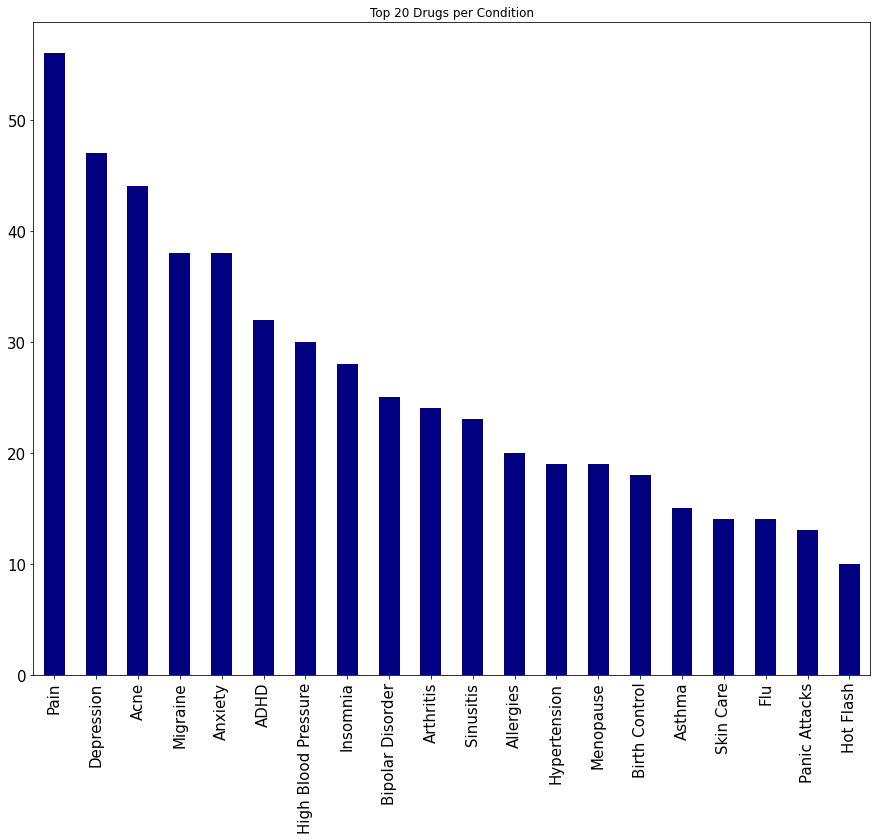

In [21]:
plot_drug_per_condition(drugs_df)

In [22]:
drugs_df.head()

,urlDrugName,rating,effectiveness_rating,sideEffect_rating,conditions,rating_class,combined_reviews,usefulCount
0,enalapril,4,5,4,Heart Failure,0,"monitor blood pressure , weight and asses for ...",13
1,ortho-tri-cyclen,1,5,2,Birth Control,0,"I Hate This Birth Control, I Would Not Suggest...",8
2,ponstel,10,5,5,menstrual cramps,1,I took 2 pills at the onset of my menstrual cr...,20
3,prilosec,3,3,4,GERD,0,I was given Prilosec prescription at a dose of...,10
4,lyrica,2,3,2,Fibromyalgia,0,See above I felt extremely drugged and dopey. ...,7


Text(0.5, 1.0, 'Bottom 20: # drugs per condition')

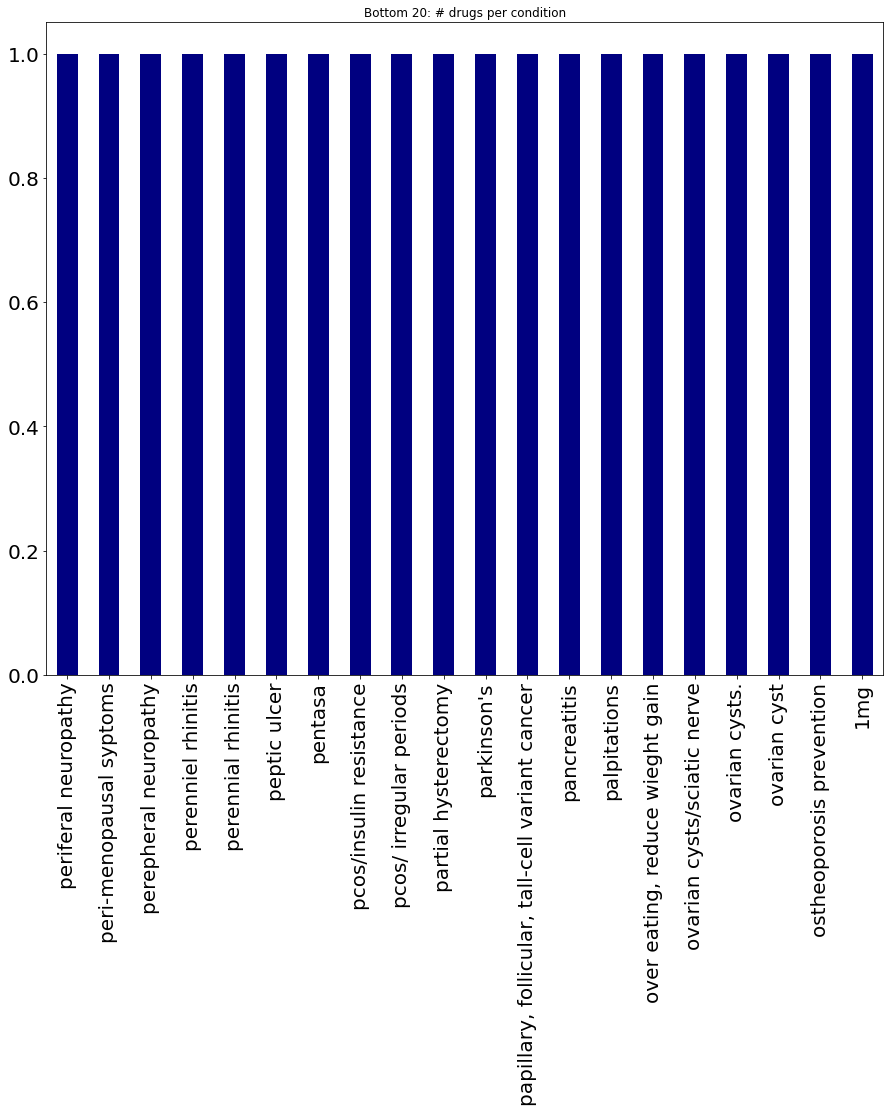

In [23]:
condition_df = drugs_df.groupby(['conditions'])['urlDrugName'].nunique().sort_values(ascending = False)

condition_df[condition_df.shape[0] - 20: condition_df.shape[0]].plot(kind = "bar", figsize = FIG_SIZE, fontsize = FONT_SIZE, color = "navy")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom 20: # drugs per condition")

In [24]:
drugs_df['usefulCount'].describe()

count    4132.000000
mean       14.455227
std         4.824560
min         3.000000
25%        11.000000
50%        16.000000
75%        18.000000
max        20.000000
Name: usefulCount, dtype: float64

In [25]:
df_condition = drugs_df.groupby(['conditions'])['urlDrugName'].nunique().sort_values(ascending = False)
df_condition = pd.DataFrame(df_condition).reset_index()

df_condition.head()

,conditions,urlDrugName
0,Pain,56
1,Depression,47
2,Acne,44
3,Migraine,38
4,Anxiety,38


Removing conditions with 1 count makes sense if we had a lot of data, but we don't have that much to work with. Some manual cleaning in the `clean_condition` function could decrease that count

In [26]:
df_condition['urlDrugName'].value_counts()

1     834
2      66
3      32
4      15
6       8
7       8
5       6
8       3
9       3
14      2
38      2
19      2
10      2
13      1
56      1
47      1
18      1
20      1
23      1
24      1
25      1
28      1
30      1
32      1
44      1
15      1
Name: urlDrugName, dtype: int64

Use this to clean conditions when you have time

In [27]:
cleanable_conditions = df_condition[df_condition['urlDrugName'] == 1].reset_index()
#cleanable_conditions['conditions'][90:120]

In [28]:
stop = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stop.remove(i)

In [29]:
stemmer = SnowballStemmer('english')

In [30]:
def review_stemming(review):
  words = review.lower().split()
  stopwords = [word for word in words if not word in stop]
  stem_words = [stemmer.stem(w) for w in stopwords]

  return(' '.join(stem_words))

In [31]:
drugs_df['cleaned_reviews'] = drugs_df['combined_reviews'].apply(review_stemming)

In [32]:
drugs_df.head(2)

,urlDrugName,rating,effectiveness_rating,sideEffect_rating,conditions,rating_class,combined_reviews,usefulCount,cleaned_reviews
0,enalapril,4,5,4,Heart Failure,0,"monitor blood pressure , weight and asses for ...",13,"monitor blood pressur , weight ass resolut flu..."
1,ortho-tri-cyclen,1,5,2,Birth Control,0,"I Hate This Birth Control, I Would Not Suggest...",8,"hate birth control, would not suggest anyone. ..."


##Model

In [ ]:
#df_train, df_test = train_test_split(drugs_df, test_size = 0.3, random_state = 2)

In [33]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             max_features = 1572
                            )
#count_train = vectorizer.fit_transform(df_train)
transformer=TfidfTransformer()

In [34]:
#pipeline = Pipeline([('vect', vectorizer),
#                     ('trans', transformer)])

pipeline = Pipeline([('vect', vectorizer),])

In [35]:
%time features = pipeline.fit_transform(drugs_df['cleaned_reviews'])
num_feats = to_categorical(drugs_df['rating_class'])

data = sparse.hstack((features, num_feats))

df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 2)

CPU times: user 192 ms, sys: 2.84 ms, total: 195 ms
Wall time: 198 ms


In [36]:
y_train = df_train[:, 1572:1575]
y_test = df_test[:, 1572:1575]
x_train = df_train[:, 0:1572]
x_test = df_test[:, 0:1572]
solution = y_test.copy

In [39]:
'''
y_train = df_train['rating_class']
y_test = df_test['rating_class']
sol = y_test.copy()
'''

"\ny_train = df_train['rating_class']\ny_test = df_test['rating_class']\nsol = y_test.copy()\n"

In [40]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(1572,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(7, activation='sigmoid'))



model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
fit = model.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data=(x_test, y_test))
model.summary()

Epoch 1/10


TypeError: ignored

##LightGBM

In [41]:
target = df_train['rating_class']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

X_train, X_val, y_train, y_val = train_test_split(df_train[feats], target, test_size = 0.2, random_state = 2)

feature_importance_df = pd.DataFrame()

clf = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.00001,
        num_leaves=20,
        colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(X_train, y_train, 
        eval_set= [(X_train, y_train), (X_val, y_val)], 
        verbose=100, early_stopping_rounds=200  #30
    )

sub_preds = clf.predict(df_test[feats])

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

IndexError: ignored

In [ ]:
solution = df_test['rating_class']
confusion_matrix(y_pred=sub_preds, y_true=solution)

In [ ]:
len_train = df_train.shape[0]

In [ ]:
len_train

In [ ]:
from textblob import TextBlob
from tqdm import tqdm
reviews = drugs_df['cleaned_reviews']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
drugs_df["Predict_Sentiment"] = Predict_Sentiment
drugs_df.head()


In [ ]:
reviews = drugs_df['cleaned_reviews']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
drugs_df["Predict_Sentiment2"] = Predict_Sentiment

In [ ]:
drugs_df['count_sent']=drugs_df["combined_reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)
drugs_df['count_word']=drugs_df["cleaned_reviews"].apply(lambda x: len(str(x).split()))
drugs_df['count_unique_word']=drugs_df["cleaned_reviews"].apply(lambda x: len(set(str(x).split())))
drugs_df['count_letters']=drugs_df["cleaned_reviews"].apply(lambda x: len(str(x)))
drugs_df["count_punctuations"] = drugs_df["combined_reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
drugs_df["count_words_upper"] = drugs_df["combined_reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
drugs_df["count_words_title"] = drugs_df["combined_reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
drugs_df["count_stopwords"] = drugs_df["combined_reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
drugs_df["mean_word_len"] = drugs_df["cleaned_reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
drugs_df.head(2)

In [ ]:
df_train, df_test = train_test_split(drugs_df, test_size = 0.3, random_state = 2)

In [ ]:
target = df_train['rating_class']
feats = ['usefulCount','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len']

sub_preds = np.zeros(df_test.shape[0])

X_train, X_val, y_train, y_val = train_test_split(df_train[feats], target, test_size=0.2, random_state=2) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.01,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(X_train, y_train, 
        eval_set= [(X_train, y_train), (X_val, y_val)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


In [ ]:
confusion_matrix(y_pred=sub_preds, y_true=solution)


In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Harvard Emotional Dictionary

In [ ]:
word_table = pd.read_csv("/content/drive/MyDrive/CMPE-258-PROJ/data/inquirerbasic.csv")
word_table

In [ ]:
#Positive word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negative word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  #del temp_Negativ


In [ ]:
vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['cleaned_reviews']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positive_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['cleaned_reviews']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negative_word"] = f2.sum(axis=1)

In [ ]:
df_test["Positive_ratio"] = df_test["num_Positive_word"]/(df_test["num_Positive_word"]+df_test["num_Negative_word"])
df_test["sentiment_by_dic"] = df_test["Positive_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head(1)

In [ ]:
def userful_count(data):
    grouped = data.groupby(['conditions']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='conditions',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [ ]:
df_test['deep_pred'] = sub_preds_deep #problem is with the model
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']